# German Traffic Sign Classifier using a LeNet based Convolutional Network

## Pipeline Approach

In this project, I'm building pipelines to classify the traffic signs from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

I'm using the scikit-learn's pipeline framework in order to train the model with various combinations of transformations and estimators.

The starting model is a convolutional network based on the [LeNet](http://yann.lecun.com/exdb/lenet/) architecture by Yann LeCun.  LeNet was originally designed for handwritten and machine-printed character recognition. 

The project is explained in the following sections.

- Data Exploratory Analysis
- Model Implementation
- Pipeline Implementation
- Preprocessing
- Model Improvement
- Testing and Results

# Data Exploratory Analysis

The traffic sign images were taken from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).  

## Training Data Folder Structure

The training images are organized in folders by category.  Each folder is meant for one category (i.e. stop sign) and has a label file (.csv) which is actually semi-colon delimited (not comma delimited).

```
data
 + Final_Training
    + Images
        + 00000
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00000.csv
        + 00001
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00001.csv
        ...
```

All images are stored in the PPM format ([Portable Pixmap, P6](http://en.wikipedia.org/wiki/Netpbm_format)).  You'll need to install both `matplotlib` and `pillow` to handle such image format.  If you use one of the evironments yml files in this repository, this will be taken care of.

## Import Required Libraries

In [1]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow as tf
from tensorflow.contrib.layers import flatten

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Loading Training Data

All train image paths are combined into one dataframe for convenience.

In [2]:
TRAIN_IMAGE_DIR = 'data/Final_Training/Images'

dfs = []
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR, '*/GT-*.csv')):
    folder = train_file.split('/')[3]
    df = pd.read_csv(train_file, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR, folder, x))
    dfs.append(df)

In [3]:
train_df = pd.concat(dfs, ignore_index=True)
train_df.head()

Filename  Width  Height  Roi.X1  \
0  data/Final_Training/Images/00000/00000_00000.ppm     29      30       5   
1  data/Final_Training/Images/00000/00000_00001.ppm     30      30       5   
2  data/Final_Training/Images/00000/00000_00002.ppm     30      30       5   
3  data/Final_Training/Images/00000/00000_00003.ppm     31      31       5   
4  data/Final_Training/Images/00000/00000_00004.ppm     30      32       5   

   Roi.Y1  Roi.X2  Roi.Y2  ClassId  
0       6      24      25        0  
1       5      25      25        0  
2       5      25      25        0  
3       5      26      26        0  
4       6      25      26        0

**Annotation format**
- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box
- ClassId: Assigned class label

The following points are worth mentioning:
- Image sizes are not fixed
- Sign sizes are not fixed
- Sign's center location is not fixed

Later on, I'll examine sample images to further clarify those points.

## Class Distribution

There are 43 traffic sign classes in 39,209 training images.

In [4]:
N_CLASSES = np.unique(train_df['ClassId']).size  # keep this for later

print("Number of training images : {:>5}".format(train_df.shape[0]))
print("Number of classes         : {:>5}".format(N_CLASSES))

Number of training images : 39209
Number of classes         :    43


The distribution of classes are very skewed.

In [5]:
def show_class_distribution(classIDs, title):
    """
    Plot the traffic sign class distribution
    """
    plt.figure(figsize=(15, 5))
    plt.title('Class ID distribution for {}'.format(title))
    plt.hist(classIDs, bins=N_CLASSES)
    plt.show()

In [6]:
show_class_distribution(train_df['ClassId'], 'Train Data')

The name of each sign are stored in sign_names.csv file.  We can use it see the distribution per sign names.

In [7]:
sign_name_df = pd.read_csv('sign_names.csv', index_col='ClassId')
sign_name_df.head()

SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)

In [8]:
sign_name_df['Occurence'] = [sum(train_df['ClassId']==c) for c in range(N_CLASSES)]
sign_name_df.sort_values('Occurence', ascending=False)

SignName  Occurence
ClassId                                                              
2                                     Speed limit (50km/h)       2250
1                                     Speed limit (30km/h)       2220
13                                                   Yield       2160
12                                           Priority road       2100
38                                              Keep right       2070
10            No passing for vehicles over 3.5 metric tons       2010
4                                     Speed limit (70km/h)       1980
5                                     Speed limit (80km/h)       1860
25                                               Road work       1500
9                                               No passing       1470
7                                    Speed limit (100km/h)       1440
3                                     Speed limit (60km/h)       1410
8                                    Speed limit (120km/h)       1410
11                   Right-of-way at the next intersection       1320
35                                              Ahead only       1200
18                                         General caution       1200
17                                                No entry       1110
31                                   Wild animals crossing        780
14                                                    Stop        780
33                                        Turn right ahead        689
15                                             No vehicles        630
26                                         Traffic signals        600
28                                       Children crossing        540
23                                           Slippery road        510
30                                      Beware of ice/snow        450
16                Vehicles over 3.5 metric tons prohibited        420
34                                         Turn left ahead        420
6                              End of speed limit (80km/h)        420
36                                    Go straight or right        390
22                                              Bumpy road        390
40                                    Roundabout mandatory        360
20                            Dangerous curve to the right        360
21                                            Double curve        330
39                                               Keep left        300
29                                       Bicycles crossing        270
24                               Road narrows on the right        270
41                                       End of no passing        240
42       End of no passing by vehicles over 3.5 metric ...        240
32                     End of all speed and passing limits        240
27                                             Pedestrians        240
37                                     Go straight or left        210
19                             Dangerous curve to the left        210
0                                     Speed limit (20km/h)        210

The following constant is defined for later use.

In [9]:
SIGN_NAMES = sign_name_df.SignName.values
SIGN_NAMES[2]

'Speed limit (50km/h)'

## Sample Images

Let's examine some random images:

In [10]:
def load_image(image_file):
    """
    Read image file into numpy array (RGB)
    """
    return plt.imread(image_file)

In [11]:
def get_samples(image_data, num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]
    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)
    return image_data.iloc[indices][['Filename', 'ClassId']].values

In [12]:
def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

The below are 20 random sample images from the train set.

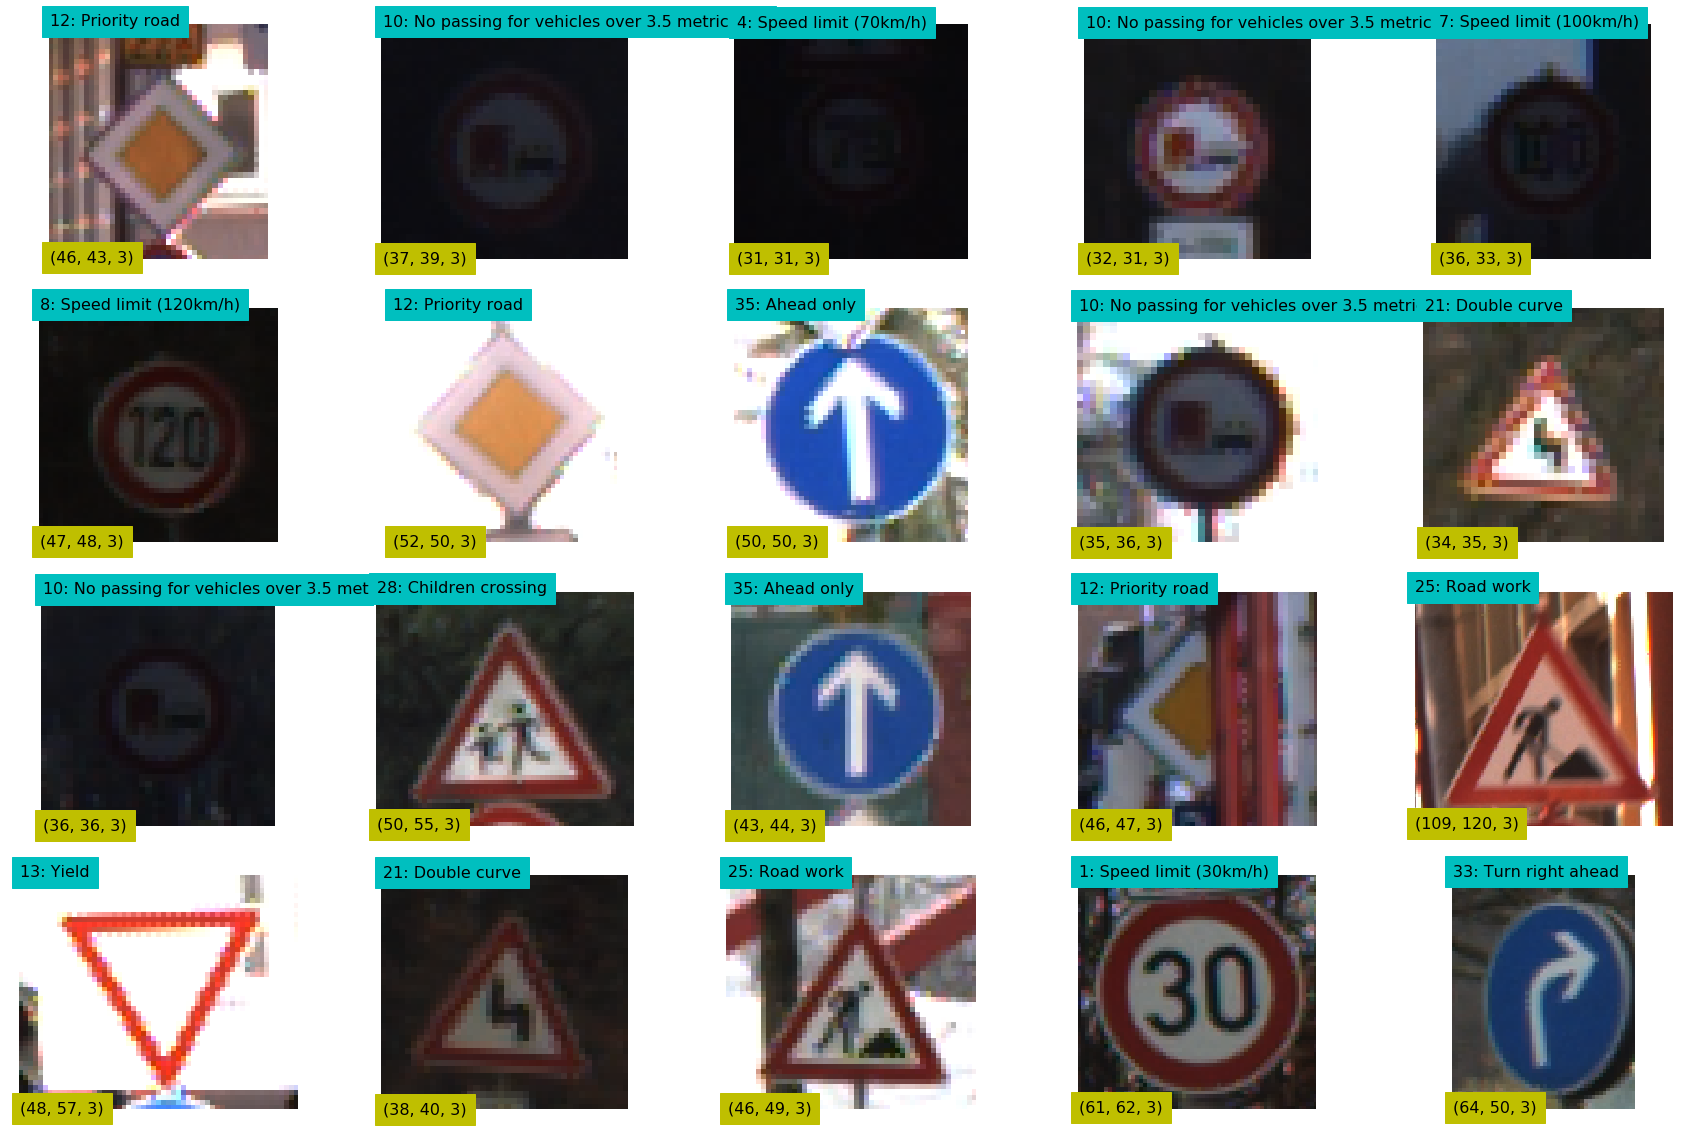

In [13]:
sample_data = get_samples(train_df, 20)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

Speed limit (50km/h)


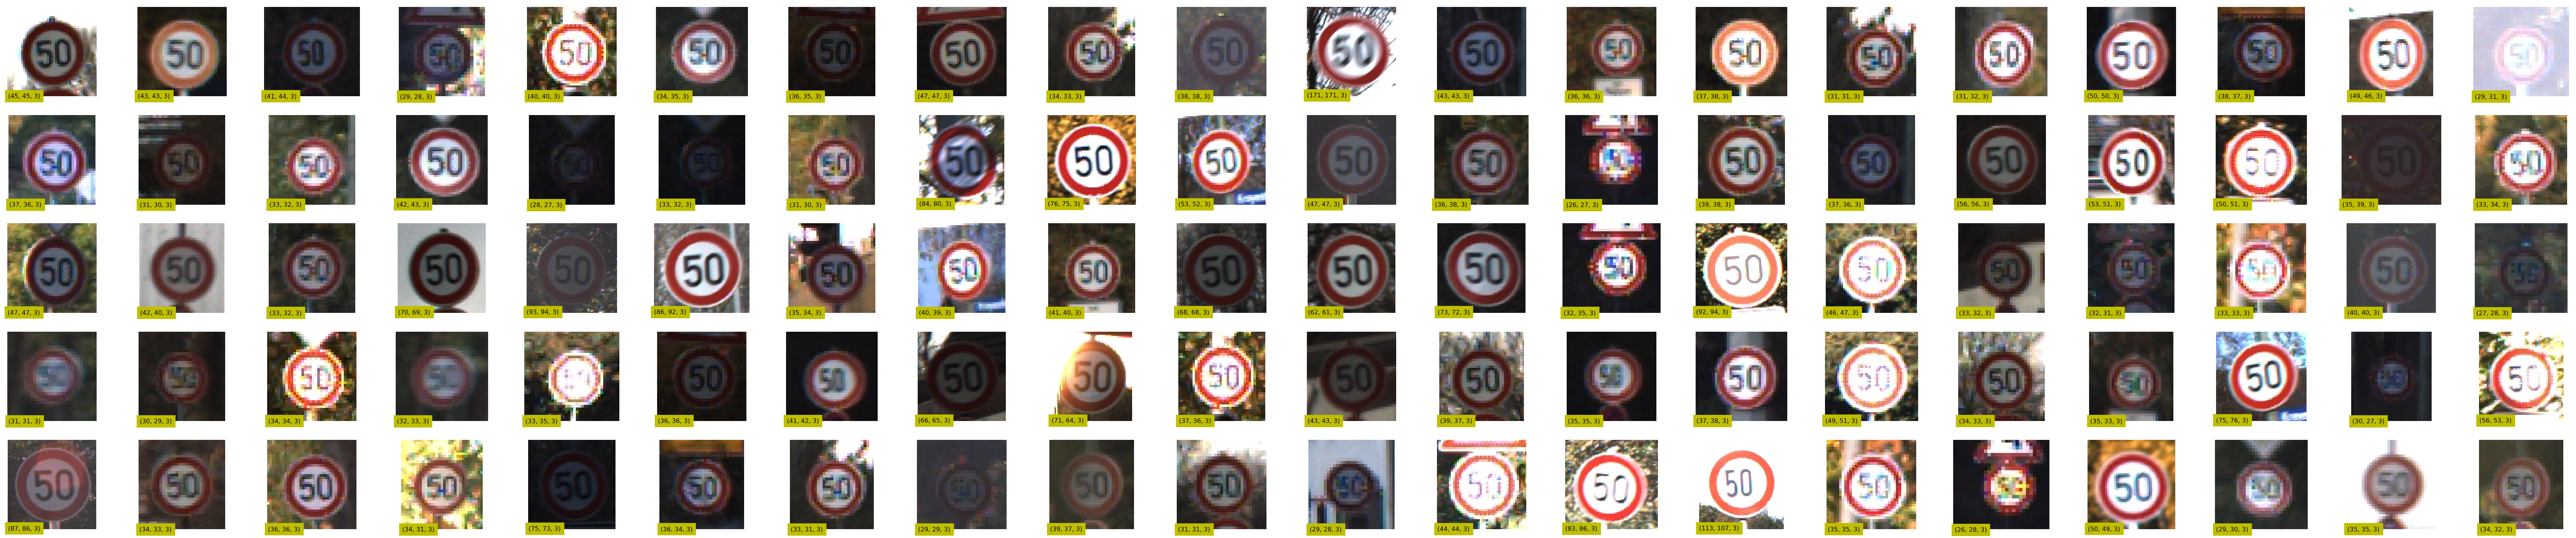

In [14]:
print(SIGN_NAMES[2])
show_images(get_samples(train_df, 100, class_id=2), cols=20, show_shape=True)

Looking at the sample images, the following image characteristics are confirmed:

- The images comes in different sizes  
- The darkness / brightness of those images are fairly random
- The images may be slightly rotated
- The images may not be facing straight
- The images may not be exactly centered
  
The first point will be handled in the image pre-processing, and the remaining points will be handled in the image augmentation.

## Train and Validation Data set

Train and validation data set are created from the training data.

In [15]:
X = train_df['Filename'].values
y = train_df['ClassId'].values

print('X data', len(X))

X data 39209


In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=8000, random_state=0)

print('X_train:', len(X_train))
print('X_valid:', len(X_valid))

X_train: 31209
X_valid: 8000


#  Model Implementation

## Model Architecture

Our model is based on [LeNet](http://yann.lecun.com/exdb/lenet/) by Yann LeCun.  It is a convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing.  It can handle hand-written characters very well. 

![LeNet](images/lenet.png)

Source: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

- The inputs are 32x32 (Black-White 1 channel) images
- LeNet uses 2x2 sub-sampling (valid padding, max pooling) in convolutional layers (no dropout)
- LeNet uses a sigmoid squashing function - a scaled hyperbolic tangent: $Atanh(Sa)$ where A=1.7159 and S=2/3
- LeNet has one 7x12 bitmap for each class, which is a label.  There are 10 classes (the digits '0' - '9')
- 7x12 = 84 which is why the output is 84
- The output is compared with all the labels (bitmaps) to calculate the error
- The class with the smallest error is an estimated digit value

Our model is adapted from the LeNet as follows.  

- The inputs are 32x32 (RGB - 3 channels) images
- The activation function is ReLU except for the output layer which uses Softmax
- The output has 43 classes

|Layer                       | Shape    |
|----------------------------|:--------:|
|Input                       | 32x32x3  |
|Convolution (valid, 5x5x6)  | 28x28x6  |
|Max Pooling (valid, 2x2)    | 14x14x6  |
|Activation  (ReLU)          | 14x14x6  |
|Convolution (valid, 5x5x16) | 10x10x16 |
|Max Pooling (valid, 2x2)    | 5x5x16   |
|Activation  (ReLU)          | 5x5x16   |
|Flatten                     | 400      |
|Dense                       | 120      |
|Activation  (ReLU)          | 120      |
|Dense                       | 43       |
|Activation  (Softmax)       | 43       |

## Model Implementation

The NeuralNetwork class is defined to provide common operations in neural network using Tensorflow.

In [17]:
class NeuralNetwork:
    
    def __init__(self, weight_mu=0, weight_sigma=0.1):
        self.weight_mu = weight_mu
        self.weight_sigma = weight_sigma
        self.layer = 0
        self.z = None

        
    def variable_scope(self, name=None):
        if name is not None:
            self.layer += 1
            self.layer_name = '{}_{}'.format(self.layer, name)
        return tf.variable_scope(self.layer_name)

    
    def input(self, shape):
        with self.variable_scope('input'):
            self.x = tf.placeholder(tf.float32, (None, *shape), name='x')
            self.y = tf.placeholder(tf.int64, (None), name='y')
            self.is_training = tf.placeholder(tf.bool, name='is_training')        
        self.z = self.x
        return self

    
    def W_b(self, shape):
        W = tf.Variable(tf.truncated_normal(shape=shape, mean=self.weight_mu, stddev=self.weight_sigma), name='W')
        b = tf.Variable(tf.zeros(shape[-1]), name='b')
        return W, b

    
    def conv(self, shape, strides=[1,1,1,1], padding='VALID'):
        with self.variable_scope('conv'):
            shape = (shape[0], shape[1], int(self.z.get_shape()[-1]), shape[2])
            W, b = self.W_b(shape)
            self.z = tf.nn.conv2d(self.z, W, strides=strides, padding=padding) + b
        return self
    
    
    def dense(self, size):
        with self.variable_scope('dense'):
            shape = [self.z.get_shape().as_list()[-1], size]
            W, b = self.W_b(shape)
            self.z = tf.matmul(self.z, W) + b
        return self
    
    
    def relu(self, leak_ratio=0.0):
        with self.variable_scope():
            if leak_ratio>0.0:
                self.z = tf.maximum(self.z, self.z*leak_ratio)
            else:
                self.z = tf.nn.relu(self.z)            
        return self
    
    
    def elu(self):
        with self.variable_scope():
            self.z = tf.nn.elu(self.z)
        return self
    
    
    def max_pool(self, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID'):
        with self.variable_scope():
            self.z = tf.nn.max_pool(self.z, ksize, strides, padding)
        return self
    
    
    def dropout(self, keep_prob):
        with self.variable_scope():
            self.z = tf.cond(self.is_training, lambda: tf.nn.dropout(self.z, keep_prob), lambda: self.z)
        return self
    
    
    def flatten(self):
        with self.variable_scope():
            self.z = flatten(self.z)
        return self

The first network (based on LeNet) is defined as follows:

In [18]:
INPUT_SHAPE = (32, 32, 3)

def make_network1(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 6])
            .max_pool()
            .relu()
            .conv([5, 5, 16])
            .max_pool()
            .relu()
            .flatten()
            .dense(120)
            .relu()
            .dense(N_CLASSES))

To use a Tensorflow network, one needs a Session object.

The below is a convenient method for handling Tensorflow session objects.

In [19]:
class Session:
    def __init__(self):
        """
        Clean up the default graph first and then create a new session
        """
        tf.reset_default_graph()
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config)
        
        
    def load(self, path):
        """
        Load a session state from the checkpoint file
        """
        saver = tf.train.Saver()
        saver.restore(self.sess, path) 

        
    def save(self, path):
        """
        Save the session state into a checkpoint file
        """
        save_dir = os.path.dirname(path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        saver = tf.train.Saver()
        saver.save(self.sess, path)


    def close(self):
        """
        Close the session
        """
        if self.sess is not None:
            self.sess.close()
            self.sess = None    
            

    def __enter__(self):
        """
        For the beginning of the 'with' statement
        """
        return self
    
    
    def __exit__(self, type, value, traceback):
        """
        For the end of the 'with' statement
        """
        self.close()

To train a classifier, the following is defined.

In [20]:
def make_adam(learning_rate):
    return tf.train.AdamOptimizer(learning_rate=learning_rate)

In [21]:
class NeuralNetworkClassifier:
    def __init__(self, session, network, optimizer=None):
        self.sess = session.sess
        self.x = network.x # features
        self.y = network.y # labels
        self.z = network.z # logits
        self.is_training = network.is_training
        self.init(optimizer)
        
        
    def init(self, optimizer):
        """
        Build optimization and prediction operators
        """
        with tf.variable_scope('evaluation'):
            one_hot_y = tf.one_hot(self.y, self.z.get_shape()[-1], name='one_hot_y')
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.z, labels=one_hot_y), name='loss')

        if optimizer:
            with tf.variable_scope('training'):
                self.training = optimizer.minimize(loss)

        with tf.variable_scope('prediction'):
            self.prediction = tf.argmax(self.z, 1, name='prediction')
            
        self.sess.run(tf.global_variables_initializer())


    def train(self, x, y):
        """
        Perform the training
        """
        self.sess.run(self.training, feed_dict={self.x: x, self.y: y, self.is_training: True})

    
    def predict(self, x):
        """
        Perform the prediction
        """
        return self.sess.run(self.prediction, feed_dict={self.x: x, self.is_training: False})    

So, we can train a classifier as follows:

```python
with Session() as session:
    # construct the network
    network = make_network1()
    optimizer = make_adam(1.0e-3)
    nnc = NeuralNetworkClassifier(session, network, optimizer)
    
    # restore the saved parameter values into the network
    session.load('checkpoint/mymodel1.ckpt')
    
    # further training
    nnc.train(...features..., ...labels...)
    # save the current session state
    session.save('checkpoint/mymodel2.ckpt')
    
    # more training
    nnc.train(...features..., ...labels...)
    #... do something more and save another ...
    session.save('checkpoint/mymodel3.ckpt')
    
    ...
    
    # session will be automatically closed
```

## Pipeline Implementation

We need more than just the network itself.  For example, we need to load images and preprocess them.  There are many different kind of preprocessing steps.  We are using the scikit-learn's pipeline framework to handle various pipeline scenarios.

The below defines a generic transformer that can be used in the scikit-learn's pipeline framework.

In [22]:
class Transformer(BaseEstimator, TransformerMixin):
    """
    A generic transformer class that uses a given function to transform inputs
    """
    def __init__(self, func):
        self.func = func
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return np.array([self.func(x) for x in X])

The following transformer will be used to load images from file and resize them to the required shape.

In [23]:
def resize_image(image, shape=INPUT_SHAPE[:2]):
    return cv2.resize(image, shape)

loader = lambda image_file: resize_image(load_image(image_file))

The below defines a generic classifier class that can be used in the scikit-learn's pipeline framework.

In [24]:
class Estimator(BaseEstimator, ClassifierMixin):
    """
    Generic classifier class that uses a given model to handle estimator operations
    """
    def __init__(self, model, batch_size): # adjust the batch_size for your computer memory, GPU
        self.model = model
        self.batch_size = batch_size
        
    
    def fit(self, X, y):
        """
        Required by scikit-learn
        """
        for start in range(0, len(X), self.batch_size):
            end = start + self.batch_size
            self.model.train(X[start:end], y[start:end])
        return self

    
    def predict(self, X, y=None):
        """
        Required by scikit-learn
        """
        pred = []
        for start in range(0, len(X), self.batch_size):
            end = start + self.batch_size
            p = self.model.predict(X[start:end])
            pred.extend(p)
        return pred

Now we have all the ingredients to make a pipeline.

In [25]:
def build_pipeline(functions, session, network, optimizer=None, batch_size=20):
    """
    Combine a list of transformers and an estimator to make a new pipeline
    """
    transformers = [Transformer(func) for func in functions]
    classifier = NeuralNetworkClassifier(session, network, optimizer)
    estimator = Estimator(classifier, batch_size)
    return make_pipeline(*transformers, estimator)


def train_evaluate(pipeline, epochs=5, samples_per_epoch=10000, train=(X_train, y_train), test=(X_valid, y_valid)):
    """
    Repeat the training for the epochs and evaluate the performance
    """
    X, y = train
    learning_curve = []
    for i in range(epochs):
        indices = np.random.choice(len(X), size=samples_per_epoch)
        pipeline.fit(X[indices], y[indices])
        scores = [pipeline.score(*train), pipeline.score(*test)]
        learning_curve.append([i, *scores])
        print("Epoch: {:>3} Train Score: {:.3f} Evaluation Score: {:.3f}".format(i, *scores))
    return np.array(learning_curve).T # (epochs, train scores, eval scores)

### Base Performance

Let's train a network using the first network.  This performance is our initial benchmark.

In [26]:
with Session() as session:
    functions = [loader]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Train Score: 0.077 Evaluation Score: 0.077
Epoch:   1 Train Score: 0.077 Evaluation Score: 0.075
Epoch:   2 Train Score: 0.221 Evaluation Score: 0.217
Epoch:   3 Train Score: 0.540 Evaluation Score: 0.528
Epoch:   4 Train Score: 0.669 Evaluation Score: 0.665


# Preprocessing

## Image Augmentation

As the training set has very skewed distribution, if I simply increases the epochs or samples per epoch, the network will overfit to the training set.  Hence, we should generate more training data using image augmentation.

In [27]:
def random_brightness(image, ratio):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.float64(hsv[:, :, 2])
    brightness = brightness * (1.0 + np.random.uniform(-ratio, ratio))
    brightness[brightness>255] = 255
    brightness[brightness<0] = 0
    hsv[:, :, 2] = brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def random_rotation(image, angle):
    """
    Randomly rotate the image
    """
    if angle == 0:
        return image
    angle = np.random.uniform(-angle, angle)
    rows, cols = image.shape[:2]
    size = cols, rows
    center = cols/2, rows/2
    scale = 1.0
    rotation = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rotation, size)


def random_translation(image, translation):
    """
    Randomly move the image
    """
    if translation == 0:
        return 0
    rows, cols = image.shape[:2]
    size = cols, rows
    x = np.random.uniform(-translation, translation)
    y = np.random.uniform(-translation, translation)
    trans = np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image, trans, size)


def random_shear(image, shear):
    """
    Randomly distort the image
    """
    if shear == 0:
        return image
    rows, cols = image.shape[:2]
    size = cols, rows
    left, right, top, bottom = shear, cols - shear, shear, rows - shear
    dx = np.random.uniform(-shear, shear)
    dy = np.random.uniform(-shear, shear)
    p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
    p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
    move = cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image, move, size)
    
    
def augment_image(image, brightness, angle, translation, shear):
    image = random_brightness(image, brightness)
    image = random_rotation(image, angle)
    image = random_translation(image, translation)
    image = random_shear(image, shear)
    return image

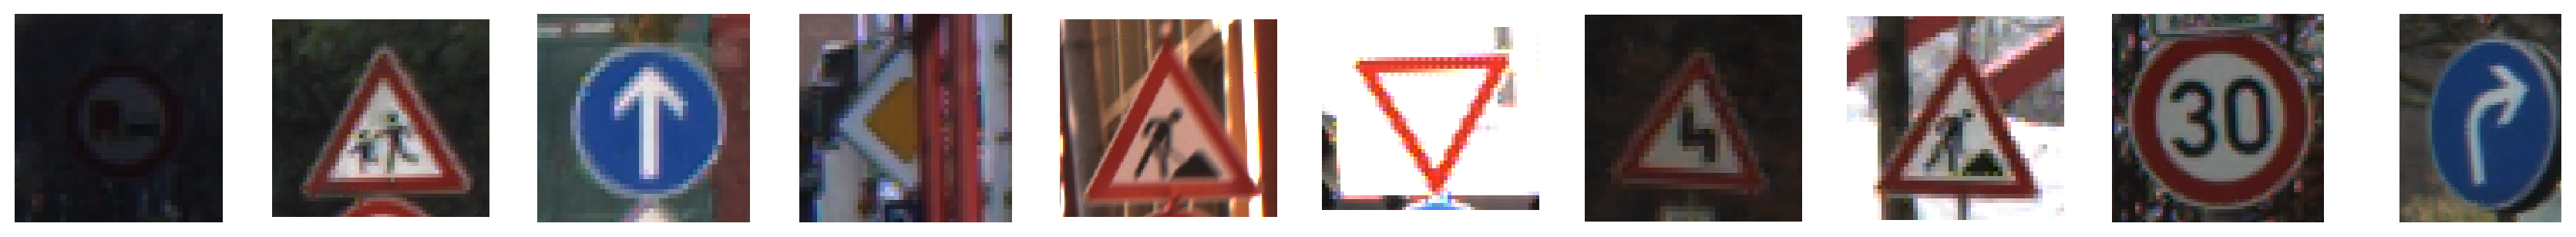

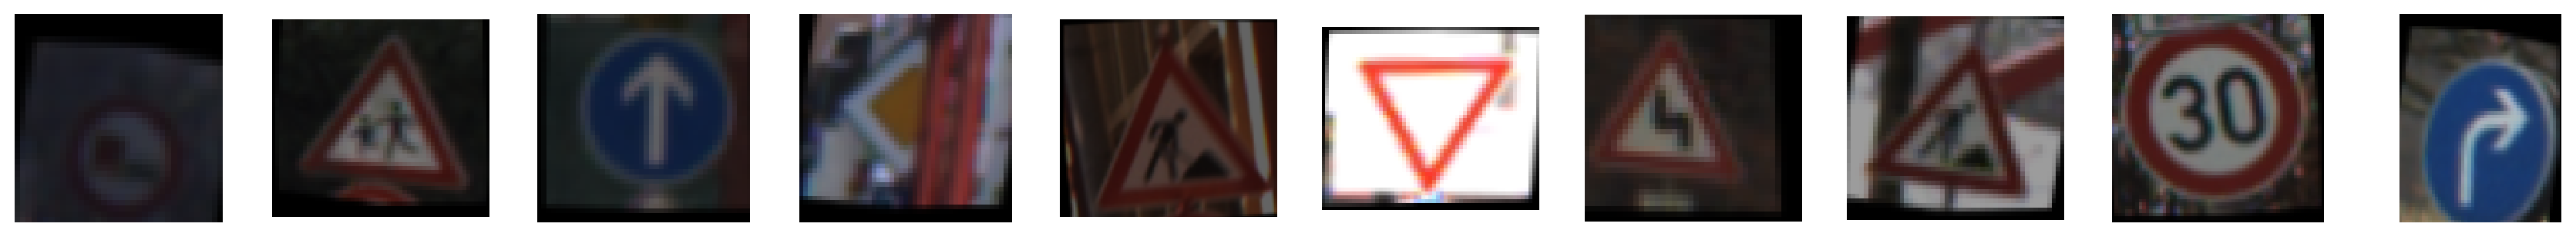

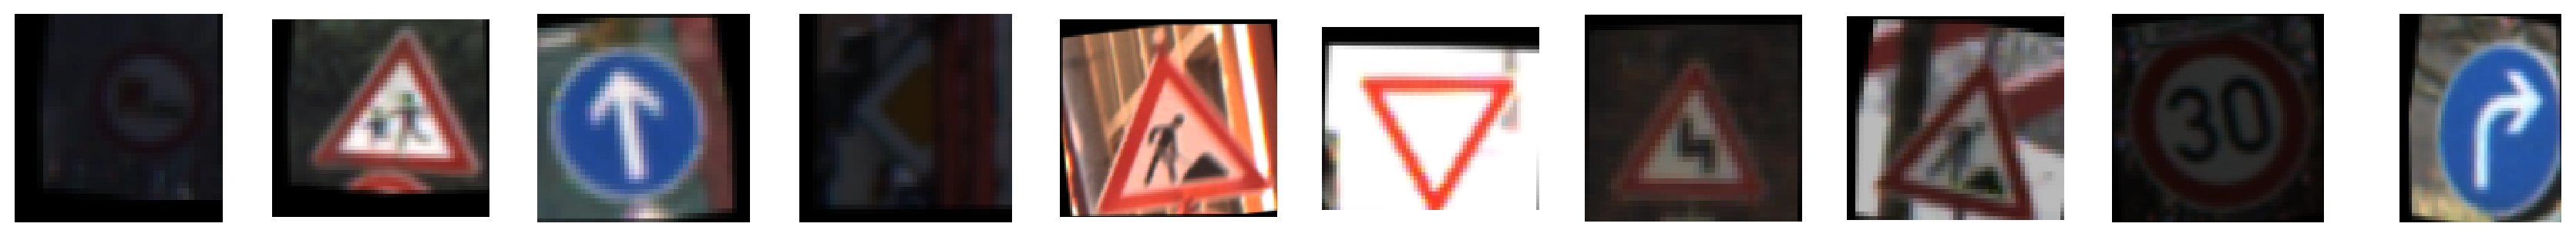

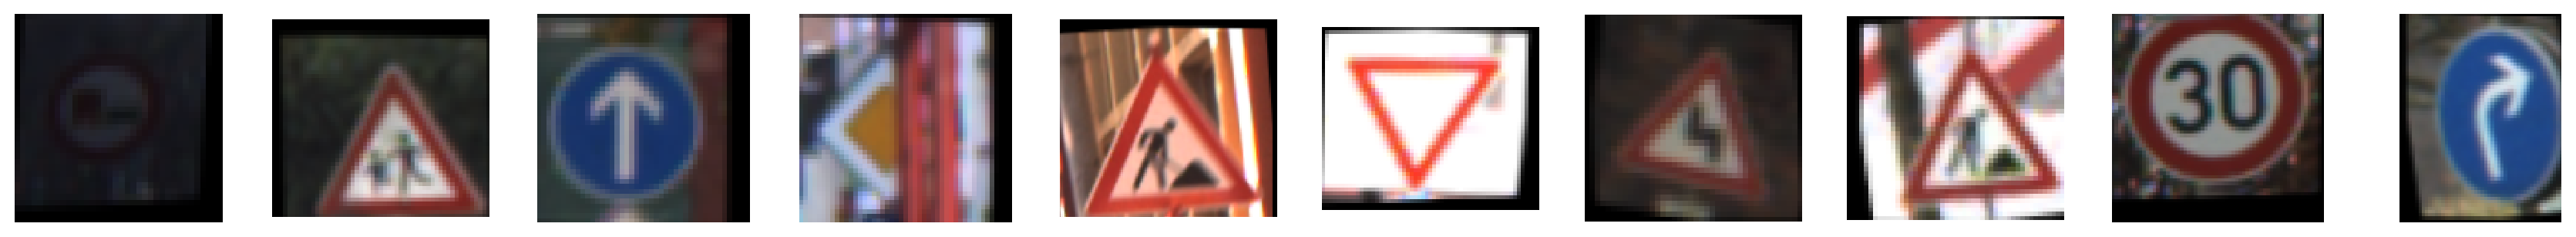

In [73]:
augmenter = lambda x: augment_image(x, brightness=0.7, angle=10, translation=5, shear=2)

show_images(sample_data[10:], cols=10) # original
for _ in range(5):
    show_images(sample_data[10:], cols=10, func=augmenter)

In [29]:
with Session() as session:
    functions = [loader, augmenter]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Train Score: 0.098 Evaluation Score: 0.094
Epoch:   1 Train Score: 0.163 Evaluation Score: 0.163
Epoch:   2 Train Score: 0.250 Evaluation Score: 0.252
Epoch:   3 Train Score: 0.308 Evaluation Score: 0.312
Epoch:   4 Train Score: 0.336 Evaluation Score: 0.340


The pipeline has very high bias.  

## Data Normalization

The below will test various normalization technique to see which one has the best performance.

In [30]:
normalizers = [('x - 127.5',              lambda x: x - 127.5), 
               ('x/127.5 - 1.0',          lambda x: x/127.5 - 1.0), 
               ('x/255.0 - 0.5',          lambda x: x/255.0 - 0.5),
               ('x - x.mean()',           lambda x: x - x.mean()),
               ('(x - x.mean())/x.std()', lambda x: (x - x.mean())/x.std())]
                
for name, normalizer in normalizers:
    print('Normalizer: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, normalizer]
        pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Normalizer: x - 127.5
Epoch:   0 Train Score: 0.076 Evaluation Score: 0.071
Epoch:   1 Train Score: 0.129 Evaluation Score: 0.130
Epoch:   2 Train Score: 0.212 Evaluation Score: 0.212
Epoch:   3 Train Score: 0.296 Evaluation Score: 0.297
Epoch:   4 Train Score: 0.373 Evaluation Score: 0.363

Normalizer: x/127.5 - 1.0
Epoch:   0 Train Score: 0.308 Evaluation Score: 0.307
Epoch:   1 Train Score: 0.408 Evaluation Score: 0.401
Epoch:   2 Train Score: 0.499 Evaluation Score: 0.499
Epoch:   3 Train Score: 0.559 Evaluation Score: 0.557
Epoch:   4 Train Score: 0.609 Evaluation Score: 0.604

Normalizer: x/255.0 - 0.5
Epoch:   0 Train Score: 0.239 Evaluation Score: 0.239
Epoch:   1 Train Score: 0.330 Evaluation Score: 0.331
Epoch:   2 Train Score: 0.428 Evaluation Score: 0.421
Epoch:   3 Train Score: 0.522 Evaluation Score: 0.520
Epoch:   4 Train Score: 0.565 Evaluation Score: 0.567

Normalizer: x - x.mean()
Epoch:   0 Train Score: 0.223 Evaluation Score: 0.224
Epoch:   1 Train Score: 0.340 Eval

The best one is kept in the normalizer variable.

In [31]:
normalizer = lambda x: (x - x.mean())/x.std()

## Color Space

Now, we'll try difference color space to see if there is any performance gain.

Note: Gray scale has only one channel so it needs to be handled separately.

**Color Code Reference**:

- http://docs.opencv.org/3.2.0/de/d25/imgproc_color_conversions.html
- https://en.wikipedia.org/wiki/CIE_1931_color_space

In [32]:
# for Gray scale, we need to add the 3rd dimension back (1 channel) as it's expected by the network
converters = [('Gray', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:, :, np.newaxis]),
              ('HSV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HSV)),
              ('HLS', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HLS)),
              ('Lab', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Lab)),
              ('Luv', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Luv)),
              ('XYZ', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2XYZ)),
              ('Yrb', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)),
              ('YUV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))]

for name, converter in converters:
    print('Color Space: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, converter, normalizer]
        if name == 'Gray':
            network = make_network1(input_shape=(*INPUT_SHAPE[:2], 1)) # there is only one channel in gray scale
        else:
            network = make_network1()
        pipeline = build_pipeline(functions, session, network, make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Color Space: Gray
Epoch:   0 Train Score: 0.357 Evaluation Score: 0.353
Epoch:   1 Train Score: 0.494 Evaluation Score: 0.493
Epoch:   2 Train Score: 0.596 Evaluation Score: 0.584
Epoch:   3 Train Score: 0.628 Evaluation Score: 0.622
Epoch:   4 Train Score: 0.688 Evaluation Score: 0.694

Color Space: HSV
Epoch:   0 Train Score: 0.284 Evaluation Score: 0.292
Epoch:   1 Train Score: 0.416 Evaluation Score: 0.412
Epoch:   2 Train Score: 0.478 Evaluation Score: 0.477
Epoch:   3 Train Score: 0.531 Evaluation Score: 0.531
Epoch:   4 Train Score: 0.565 Evaluation Score: 0.568

Color Space: HLS
Epoch:   0 Train Score: 0.254 Evaluation Score: 0.254
Epoch:   1 Train Score: 0.341 Evaluation Score: 0.336
Epoch:   2 Train Score: 0.405 Evaluation Score: 0.399
Epoch:   3 Train Score: 0.448 Evaluation Score: 0.446
Epoch:   4 Train Score: 0.501 Evaluation Score: 0.502

Color Space: Lab
Epoch:   0 Train Score: 0.272 Evaluation Score: 0.270
Epoch:   1 Train Score: 0.401 Evaluation Score: 0.398
Epoch:   2

The RGB (no color conversion) is the best choice.

## Image Enhancement

Taking a weighted average of the original image and the blurred image to make in order to smooth out the noises.

In [33]:
def enhance_image(image, ksize, weight):
    blurred = cv2.GaussianBlur(image, (ksize, ksize), 0)
    return cv2.addWeighted(image, weight, blurred, -weight, image.mean())

In [34]:
for ksize in [5, 7, 9, 11, 13, 15]:
    for weight in [2, 4, 6, 8, 10, 12]:
        print('Gaussian Blur: k={} w={}'.format(ksize, weight))
        with Session() as session:
            enhancer = lambda x: enhance_image(x, ksize, weight)
            functions = [loader, augmenter, enhancer, normalizer]
            pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
            train_evaluate(pipeline)
        print()

Gaussian Blur: k=5 w=2
Epoch:   0 Train Score: 0.407 Evaluation Score: 0.407
Epoch:   1 Train Score: 0.527 Evaluation Score: 0.525
Epoch:   2 Train Score: 0.598 Evaluation Score: 0.598
Epoch:   3 Train Score: 0.631 Evaluation Score: 0.632
Epoch:   4 Train Score: 0.702 Evaluation Score: 0.700

Gaussian Blur: k=5 w=4
Epoch:   0 Train Score: 0.389 Evaluation Score: 0.392
Epoch:   1 Train Score: 0.542 Evaluation Score: 0.543
Epoch:   2 Train Score: 0.634 Evaluation Score: 0.627
Epoch:   3 Train Score: 0.680 Evaluation Score: 0.679
Epoch:   4 Train Score: 0.731 Evaluation Score: 0.734

Gaussian Blur: k=5 w=6
Epoch:   0 Train Score: 0.415 Evaluation Score: 0.417
Epoch:   1 Train Score: 0.563 Evaluation Score: 0.549
Epoch:   2 Train Score: 0.611 Evaluation Score: 0.615
Epoch:   3 Train Score: 0.701 Evaluation Score: 0.701
Epoch:   4 Train Score: 0.711 Evaluation Score: 0.713

Gaussian Blur: k=5 w=8
Epoch:   0 Train Score: 0.381 Evaluation Score: 0.376
Epoch:   1 Train Score: 0.512 Evaluation 

In [35]:
enhancer = lambda x: enhance_image(x, 13, 6)

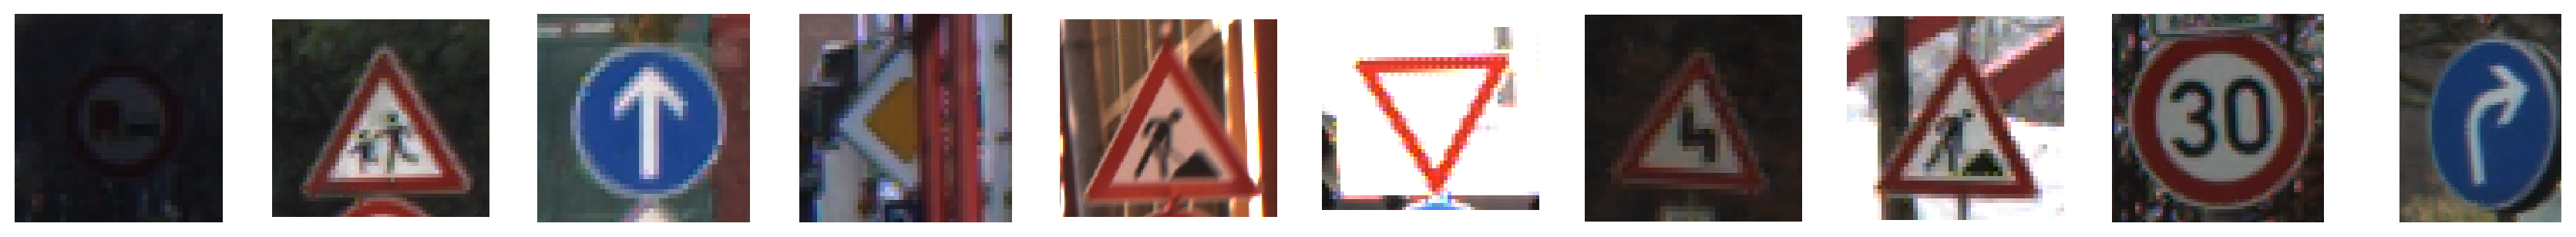

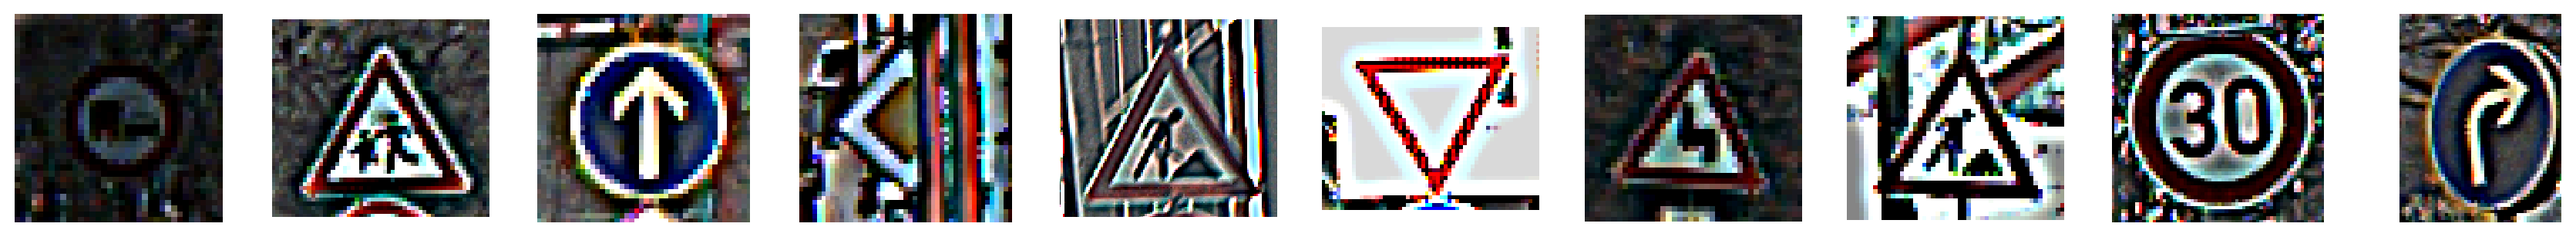

In [36]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=enhancer)

## Histogram Equalizaition

In [37]:
def equalizer(image):
    image = image.copy()
    for i in range(3):
        image[:, :, i] = cv2.equalizeHist(image[:, :, i])
    return image

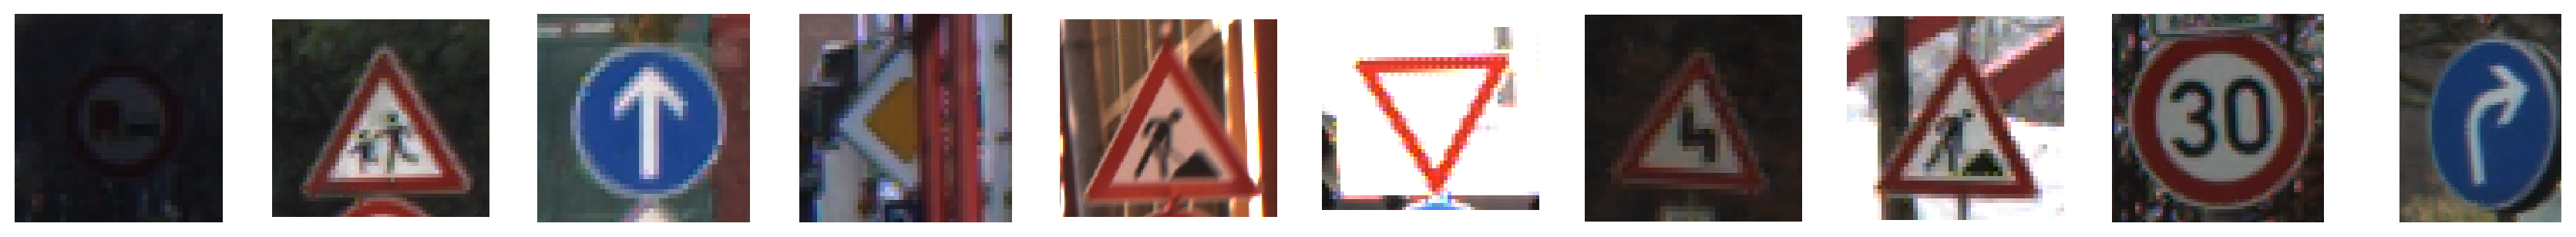

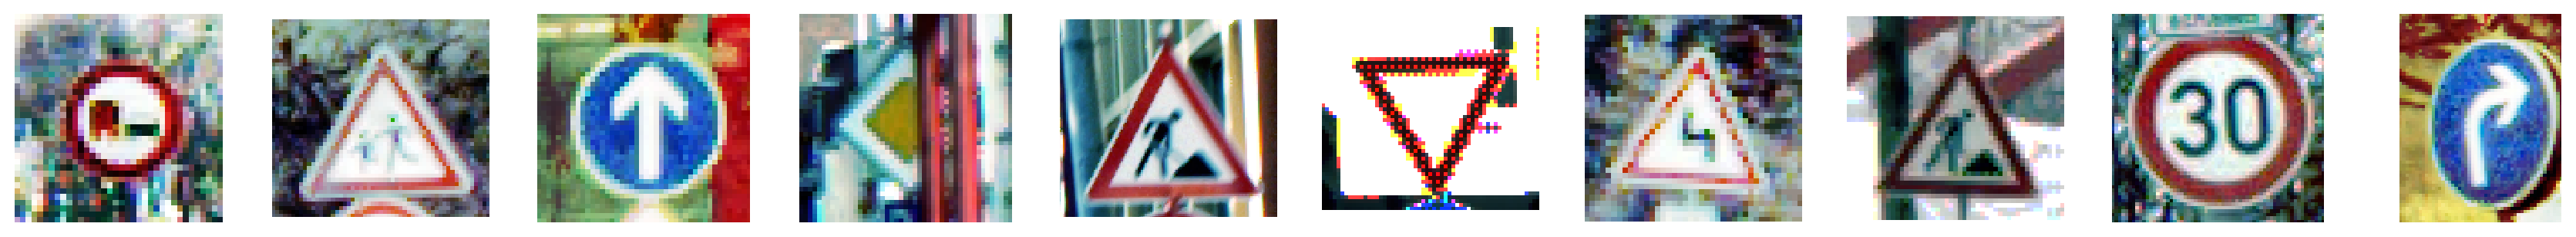

In [38]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=equalizer)

In [39]:
with Session() as session:
    functions = [loader, augmenter, equalizer, normalizer]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Train Score: 0.407 Evaluation Score: 0.406
Epoch:   1 Train Score: 0.542 Evaluation Score: 0.546
Epoch:   2 Train Score: 0.601 Evaluation Score: 0.589
Epoch:   3 Train Score: 0.660 Evaluation Score: 0.658
Epoch:   4 Train Score: 0.701 Evaluation Score: 0.697


How about combine the histogram equalizer and the enhancer?

In [40]:
with Session() as session:
    functions = [loader, augmenter, equalizer, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Train Score: 0.376 Evaluation Score: 0.381
Epoch:   1 Train Score: 0.525 Evaluation Score: 0.522
Epoch:   2 Train Score: 0.621 Evaluation Score: 0.615
Epoch:   3 Train Score: 0.672 Evaluation Score: 0.665
Epoch:   4 Train Score: 0.717 Evaluation Score: 0.713


The histogram equalizer does not improve better than the enhancer and it does not help the enhancer, either.

## Min Max Normalization

http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize

In [41]:
def min_max_norm(image):
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

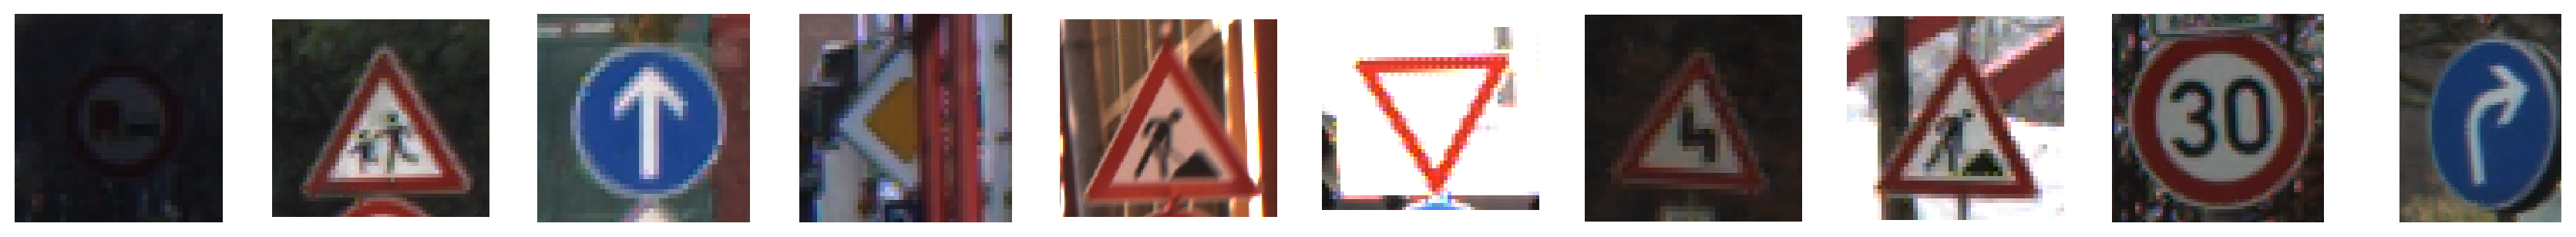

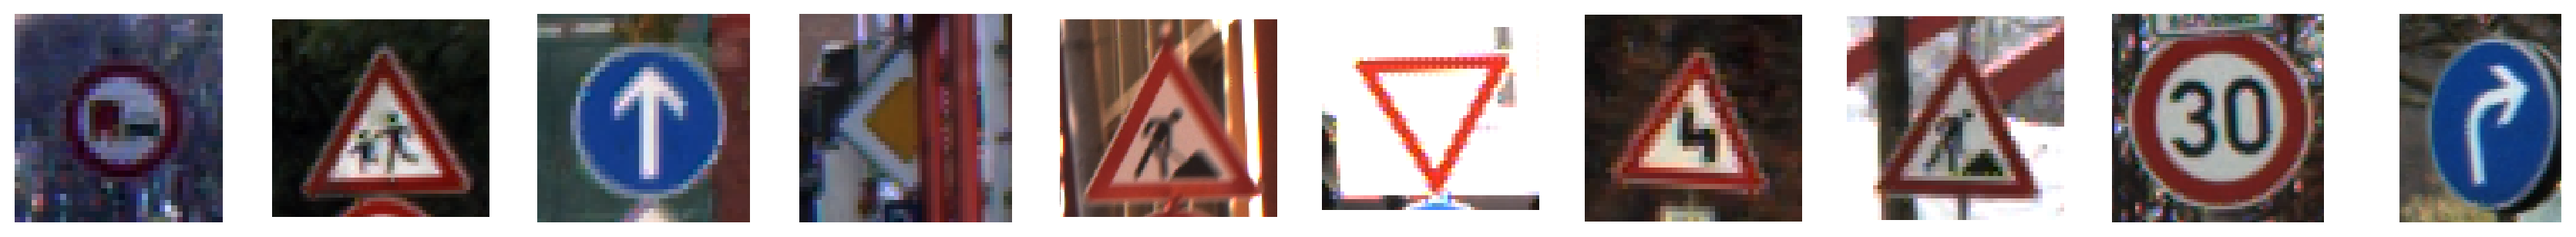

In [42]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=min_max_norm)

In [43]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, normalizer]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Train Score: 0.421 Evaluation Score: 0.415
Epoch:   1 Train Score: 0.542 Evaluation Score: 0.537
Epoch:   2 Train Score: 0.638 Evaluation Score: 0.634
Epoch:   3 Train Score: 0.706 Evaluation Score: 0.695
Epoch:   4 Train Score: 0.755 Evaluation Score: 0.753


Let's try the combination with the enhancer.

In [44]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Train Score: 0.436 Evaluation Score: 0.433
Epoch:   1 Train Score: 0.598 Evaluation Score: 0.596
Epoch:   2 Train Score: 0.668 Evaluation Score: 0.659
Epoch:   3 Train Score: 0.728 Evaluation Score: 0.727
Epoch:   4 Train Score: 0.770 Evaluation Score: 0.762


Finally, let's keep the preprocessors in a vairable.

In [45]:
preprocessors = [loader, augmenter, enhancer, normalizer]

# Model Improvement

I'm done with preprocessing part.  Next, I want to try the following to increase the model's capacity, which may leads to an overfitting but we can deal with it later using regularization.

- use more filters in conv layers
- use more neurons in dense layers
- use more conv layers 
- use more dense layers
- use different activation like `elu` instead of `relu`

## Network 2

Doubling all filters in the convolutional layers and neurons in the dense layers.

In [46]:
def make_network2(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 12])  # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 32])  # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(240) # <== doubled
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network2(), make_adam(1.0e-3))
    train_evaluate(pipeline)
    session.save('checkpoint/network2.ckpt')

Epoch:   0 Train Score: 0.529 Evaluation Score: 0.528
Epoch:   1 Train Score: 0.714 Evaluation Score: 0.708
Epoch:   2 Train Score: 0.802 Evaluation Score: 0.795
Epoch:   3 Train Score: 0.832 Evaluation Score: 0.831
Epoch:   4 Train Score: 0.861 Evaluation Score: 0.858


The performance improved and there is no sign of overfitting.

## Network 3

Futher doubling all filters in the convolutional layers and neurons in the dense layers.

In [47]:
def make_network3(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 64]) # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(480)  # <== doubled
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-3))
    train_evaluate(pipeline)
    session.save('checkpoint/network3.ckpt')

Epoch:   0 Train Score: 0.524 Evaluation Score: 0.508
Epoch:   1 Train Score: 0.697 Evaluation Score: 0.685
Epoch:   2 Train Score: 0.796 Evaluation Score: 0.789
Epoch:   3 Train Score: 0.832 Evaluation Score: 0.829
Epoch:   4 Train Score: 0.860 Evaluation Score: 0.856


The performance did not improve.

## Network 3 with More Epochs

I should probably add more epochs as the performance keeps improving.

In [48]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-3))
    train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20.ckpt')    

Epoch:   0 Train Score: 0.599 Evaluation Score: 0.596
Epoch:   1 Train Score: 0.754 Evaluation Score: 0.748
Epoch:   2 Train Score: 0.817 Evaluation Score: 0.814
Epoch:   3 Train Score: 0.865 Evaluation Score: 0.859
Epoch:   4 Train Score: 0.891 Evaluation Score: 0.891
Epoch:   5 Train Score: 0.891 Evaluation Score: 0.888
Epoch:   6 Train Score: 0.913 Evaluation Score: 0.908
Epoch:   7 Train Score: 0.924 Evaluation Score: 0.917
Epoch:   8 Train Score: 0.930 Evaluation Score: 0.932
Epoch:   9 Train Score: 0.940 Evaluation Score: 0.936
Epoch:  10 Train Score: 0.947 Evaluation Score: 0.948
Epoch:  11 Train Score: 0.940 Evaluation Score: 0.938
Epoch:  12 Train Score: 0.955 Evaluation Score: 0.948
Epoch:  13 Train Score: 0.953 Evaluation Score: 0.949
Epoch:  14 Train Score: 0.956 Evaluation Score: 0.952
Epoch:  15 Train Score: 0.952 Evaluation Score: 0.947
Epoch:  16 Train Score: 0.959 Evaluation Score: 0.957
Epoch:  17 Train Score: 0.957 Evaluation Score: 0.953
Epoch:  18 Train Score: 0.95

The performance did improve but not in the last several epochs.

## Network 3 with More Epochs and Lower Learning Rate

Let's try lowering learning rate.

In [49]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) # <== lower learning rate
    train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_lr-0.5e-3.ckpt')    

Epoch:   0 Train Score: 0.466 Evaluation Score: 0.463
Epoch:   1 Train Score: 0.650 Evaluation Score: 0.650
Epoch:   2 Train Score: 0.756 Evaluation Score: 0.760
Epoch:   3 Train Score: 0.820 Evaluation Score: 0.817
Epoch:   4 Train Score: 0.850 Evaluation Score: 0.845
Epoch:   5 Train Score: 0.873 Evaluation Score: 0.867
Epoch:   6 Train Score: 0.895 Evaluation Score: 0.895
Epoch:   7 Train Score: 0.895 Evaluation Score: 0.891
Epoch:   8 Train Score: 0.901 Evaluation Score: 0.890
Epoch:   9 Train Score: 0.914 Evaluation Score: 0.910
Epoch:  10 Train Score: 0.928 Evaluation Score: 0.925
Epoch:  11 Train Score: 0.934 Evaluation Score: 0.932
Epoch:  12 Train Score: 0.939 Evaluation Score: 0.938
Epoch:  13 Train Score: 0.955 Evaluation Score: 0.951
Epoch:  14 Train Score: 0.943 Evaluation Score: 0.942
Epoch:  15 Train Score: 0.954 Evaluation Score: 0.954
Epoch:  16 Train Score: 0.955 Evaluation Score: 0.953
Epoch:  17 Train Score: 0.959 Evaluation Score: 0.956
Epoch:  18 Train Score: 0.95

It did not improve.

## Network 4

Let's try leaky ReLU (to avoid dead ReLU issue if any)

In [50]:
def make_network4(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .conv([5, 5, 64])
            .max_pool()
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .flatten()
            .dense(480)
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4(), make_adam(0.5e-3))
    train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network4.ckpt')

Epoch:   0 Train Score: 0.494 Evaluation Score: 0.484
Epoch:   1 Train Score: 0.635 Evaluation Score: 0.634
Epoch:   2 Train Score: 0.756 Evaluation Score: 0.758
Epoch:   3 Train Score: 0.813 Evaluation Score: 0.808
Epoch:   4 Train Score: 0.841 Evaluation Score: 0.839
Epoch:   5 Train Score: 0.881 Evaluation Score: 0.882
Epoch:   6 Train Score: 0.899 Evaluation Score: 0.895
Epoch:   7 Train Score: 0.913 Evaluation Score: 0.911
Epoch:   8 Train Score: 0.917 Evaluation Score: 0.911
Epoch:   9 Train Score: 0.923 Evaluation Score: 0.920
Epoch:  10 Train Score: 0.931 Evaluation Score: 0.930
Epoch:  11 Train Score: 0.931 Evaluation Score: 0.930
Epoch:  12 Train Score: 0.944 Evaluation Score: 0.943
Epoch:  13 Train Score: 0.955 Evaluation Score: 0.953
Epoch:  14 Train Score: 0.938 Evaluation Score: 0.933
Epoch:  15 Train Score: 0.957 Evaluation Score: 0.954
Epoch:  16 Train Score: 0.960 Evaluation Score: 0.960
Epoch:  17 Train Score: 0.961 Evaluation Score: 0.957
Epoch:  18 Train Score: 0.95

No improvment.

## Network 5

ELU (Exponential Linear Unit) activation which is supposed to be faster to learn than ReLU.

Reference: http://www.picalike.com/blog/2015/11/28/relu-was-yesterday-tomorrow-comes-elu/

In [51]:
def make_network5(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .elu()              # <== ELU
            .conv([5, 5, 64])
            .max_pool()
            .elu()              # <== ELU
            .flatten()
            .dense(480)
            .elu()              # <== ELU
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network5(), make_adam(0.5e-3))
    train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network5.ckpt')

Epoch:   0 Train Score: 0.444 Evaluation Score: 0.443
Epoch:   1 Train Score: 0.613 Evaluation Score: 0.615
Epoch:   2 Train Score: 0.695 Evaluation Score: 0.685
Epoch:   3 Train Score: 0.763 Evaluation Score: 0.761
Epoch:   4 Train Score: 0.799 Evaluation Score: 0.796
Epoch:   5 Train Score: 0.822 Evaluation Score: 0.822
Epoch:   6 Train Score: 0.851 Evaluation Score: 0.847
Epoch:   7 Train Score: 0.864 Evaluation Score: 0.859
Epoch:   8 Train Score: 0.873 Evaluation Score: 0.865
Epoch:   9 Train Score: 0.890 Evaluation Score: 0.881
Epoch:  10 Train Score: 0.902 Evaluation Score: 0.901
Epoch:  11 Train Score: 0.911 Evaluation Score: 0.905
Epoch:  12 Train Score: 0.912 Evaluation Score: 0.903
Epoch:  13 Train Score: 0.912 Evaluation Score: 0.906
Epoch:  14 Train Score: 0.918 Evaluation Score: 0.909
Epoch:  15 Train Score: 0.928 Evaluation Score: 0.922
Epoch:  16 Train Score: 0.931 Evaluation Score: 0.923
Epoch:  17 Train Score: 0.933 Evaluation Score: 0.927
Epoch:  18 Train Score: 0.94

It did not learn faster.

## Network 6

Let's try smaller initial weight value.

In [52]:
def make_network6(input_shape=INPUT_SHAPE):
    return (NeuralNetwork(weight_sigma=0.01) # <== smaller weight sigma
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network6(), make_adam(0.5e-3))
    train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network6.ckpt')

Epoch:   0 Train Score: 0.323 Evaluation Score: 0.324
Epoch:   1 Train Score: 0.548 Evaluation Score: 0.549
Epoch:   2 Train Score: 0.698 Evaluation Score: 0.697
Epoch:   3 Train Score: 0.760 Evaluation Score: 0.764
Epoch:   4 Train Score: 0.818 Evaluation Score: 0.815
Epoch:   5 Train Score: 0.860 Evaluation Score: 0.857
Epoch:   6 Train Score: 0.884 Evaluation Score: 0.883
Epoch:   7 Train Score: 0.902 Evaluation Score: 0.901
Epoch:   8 Train Score: 0.911 Evaluation Score: 0.913
Epoch:   9 Train Score: 0.914 Evaluation Score: 0.917
Epoch:  10 Train Score: 0.928 Evaluation Score: 0.930
Epoch:  11 Train Score: 0.919 Evaluation Score: 0.925
Epoch:  12 Train Score: 0.933 Evaluation Score: 0.929
Epoch:  13 Train Score: 0.948 Evaluation Score: 0.948
Epoch:  14 Train Score: 0.953 Evaluation Score: 0.951
Epoch:  15 Train Score: 0.934 Evaluation Score: 0.929
Epoch:  16 Train Score: 0.951 Evaluation Score: 0.945
Epoch:  17 Train Score: 0.957 Evaluation Score: 0.953
Epoch:  18 Train Score: 0.95

Not an improvement.

## Network 7

Adding one more dense layer.

In [53]:
def make_network7(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(240) # <== one more dense layer
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network7(), make_adam(0.5e-3))
    train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network7.ckpt')

Epoch:   0 Train Score: 0.416 Evaluation Score: 0.408
Epoch:   1 Train Score: 0.590 Evaluation Score: 0.593
Epoch:   2 Train Score: 0.712 Evaluation Score: 0.709
Epoch:   3 Train Score: 0.776 Evaluation Score: 0.774
Epoch:   4 Train Score: 0.815 Evaluation Score: 0.812
Epoch:   5 Train Score: 0.858 Evaluation Score: 0.854
Epoch:   6 Train Score: 0.864 Evaluation Score: 0.862
Epoch:   7 Train Score: 0.881 Evaluation Score: 0.879
Epoch:   8 Train Score: 0.907 Evaluation Score: 0.907
Epoch:   9 Train Score: 0.921 Evaluation Score: 0.917
Epoch:  10 Train Score: 0.929 Evaluation Score: 0.926
Epoch:  11 Train Score: 0.929 Evaluation Score: 0.925
Epoch:  12 Train Score: 0.939 Evaluation Score: 0.937
Epoch:  13 Train Score: 0.941 Evaluation Score: 0.939
Epoch:  14 Train Score: 0.946 Evaluation Score: 0.942
Epoch:  15 Train Score: 0.952 Evaluation Score: 0.949
Epoch:  16 Train Score: 0.947 Evaluation Score: 0.946
Epoch:  17 Train Score: 0.956 Evaluation Score: 0.954
Epoch:  18 Train Score: 0.95

No improvment.

## Network 8

The same as Network 3 but using MaxPooling after ReLU.

In [54]:
def make_network8(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .relu()     
            .max_pool() # <== after ReLU
            .conv([5, 5, 64])
            .relu()
            .max_pool() # <== after ReLU
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network8(), make_adam(0.5e-3))
    train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network8.ckpt')

Epoch:   0 Train Score: 0.484 Evaluation Score: 0.487
Epoch:   1 Train Score: 0.661 Evaluation Score: 0.653
Epoch:   2 Train Score: 0.754 Evaluation Score: 0.751
Epoch:   3 Train Score: 0.805 Evaluation Score: 0.802
Epoch:   4 Train Score: 0.851 Evaluation Score: 0.846
Epoch:   5 Train Score: 0.863 Evaluation Score: 0.859
Epoch:   6 Train Score: 0.900 Evaluation Score: 0.900
Epoch:   7 Train Score: 0.904 Evaluation Score: 0.900
Epoch:   8 Train Score: 0.914 Evaluation Score: 0.907
Epoch:   9 Train Score: 0.930 Evaluation Score: 0.921
Epoch:  10 Train Score: 0.930 Evaluation Score: 0.924
Epoch:  11 Train Score: 0.940 Evaluation Score: 0.933
Epoch:  12 Train Score: 0.936 Evaluation Score: 0.928
Epoch:  13 Train Score: 0.942 Evaluation Score: 0.943
Epoch:  14 Train Score: 0.951 Evaluation Score: 0.949
Epoch:  15 Train Score: 0.955 Evaluation Score: 0.946
Epoch:  16 Train Score: 0.955 Evaluation Score: 0.950
Epoch:  17 Train Score: 0.959 Evaluation Score: 0.953
Epoch:  18 Train Score: 0.96

No improvement - actually slightly worse.

## Network 9

Let's try 3 convolutional layers.

In [55]:
def make_network9(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .conv([3, 3, 64])  # <= smaller kernel here (the image is small by here)
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network9(), make_adam(0.5e-3))
    train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network9.ckpt')

Epoch:   0 Train Score: 0.505 Evaluation Score: 0.507
Epoch:   1 Train Score: 0.697 Evaluation Score: 0.697
Epoch:   2 Train Score: 0.767 Evaluation Score: 0.758
Epoch:   3 Train Score: 0.801 Evaluation Score: 0.797
Epoch:   4 Train Score: 0.855 Evaluation Score: 0.852
Epoch:   5 Train Score: 0.858 Evaluation Score: 0.860
Epoch:   6 Train Score: 0.873 Evaluation Score: 0.874
Epoch:   7 Train Score: 0.890 Evaluation Score: 0.887
Epoch:   8 Train Score: 0.906 Evaluation Score: 0.910
Epoch:   9 Train Score: 0.897 Evaluation Score: 0.895
Epoch:  10 Train Score: 0.924 Evaluation Score: 0.922
Epoch:  11 Train Score: 0.935 Evaluation Score: 0.928
Epoch:  12 Train Score: 0.931 Evaluation Score: 0.930
Epoch:  13 Train Score: 0.935 Evaluation Score: 0.936
Epoch:  14 Train Score: 0.941 Evaluation Score: 0.938
Epoch:  15 Train Score: 0.948 Evaluation Score: 0.942
Epoch:  16 Train Score: 0.930 Evaluation Score: 0.928
Epoch:  17 Train Score: 0.954 Evaluation Score: 0.952
Epoch:  18 Train Score: 0.94

No improvment.

## Network 3 with Momentum Optimizer

In [74]:
for momentum in [0.7, 0.8, 0.9]:
    with Session() as session:
        print('Momentum: {}'.format(momentum))
        optimizer = tf.train.MomentumOptimizer(learning_rate=0.5e-3, momentum=momentum)
        pipeline = build_pipeline(preprocessors, session, make_network3(), optimizer)
        train_evaluate(pipeline, epochs=20)
        session.save('checkpoint/network3_momentum_{}.ckpt'.format(momentum))
        print()

Momentum: 0.7
Epoch:   0 Train Score: 0.150 Evaluation Score: 0.145
Epoch:   1 Train Score: 0.223 Evaluation Score: 0.222
Epoch:   2 Train Score: 0.288 Evaluation Score: 0.291
Epoch:   3 Train Score: 0.327 Evaluation Score: 0.328
Epoch:   4 Train Score: 0.374 Evaluation Score: 0.372
Epoch:   5 Train Score: 0.399 Evaluation Score: 0.403
Epoch:   6 Train Score: 0.431 Evaluation Score: 0.430
Epoch:   7 Train Score: 0.455 Evaluation Score: 0.447
Epoch:   8 Train Score: 0.478 Evaluation Score: 0.477
Epoch:   9 Train Score: 0.507 Evaluation Score: 0.503
Epoch:  10 Train Score: 0.526 Evaluation Score: 0.525
Epoch:  11 Train Score: 0.554 Evaluation Score: 0.552
Epoch:  12 Train Score: 0.571 Evaluation Score: 0.577
Epoch:  13 Train Score: 0.585 Evaluation Score: 0.583
Epoch:  14 Train Score: 0.603 Evaluation Score: 0.598
Epoch:  15 Train Score: 0.613 Evaluation Score: 0.608
Epoch:  16 Train Score: 0.629 Evaluation Score: 0.622
Epoch:  17 Train Score: 0.638 Evaluation Score: 0.628
Epoch:  18 Tra

Got worse.

## Confusion Matrix Check

Let's see how the best network is doing in more details.

In [57]:
def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()
    

def print_confusion_matrix(cm, sign_names=SIGN_NAMES):
    results = [(i, SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)]
    accuracies = []
    for result in sorted(results, key=lambda x: -x[2]):
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])
    print('-'*50)
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))

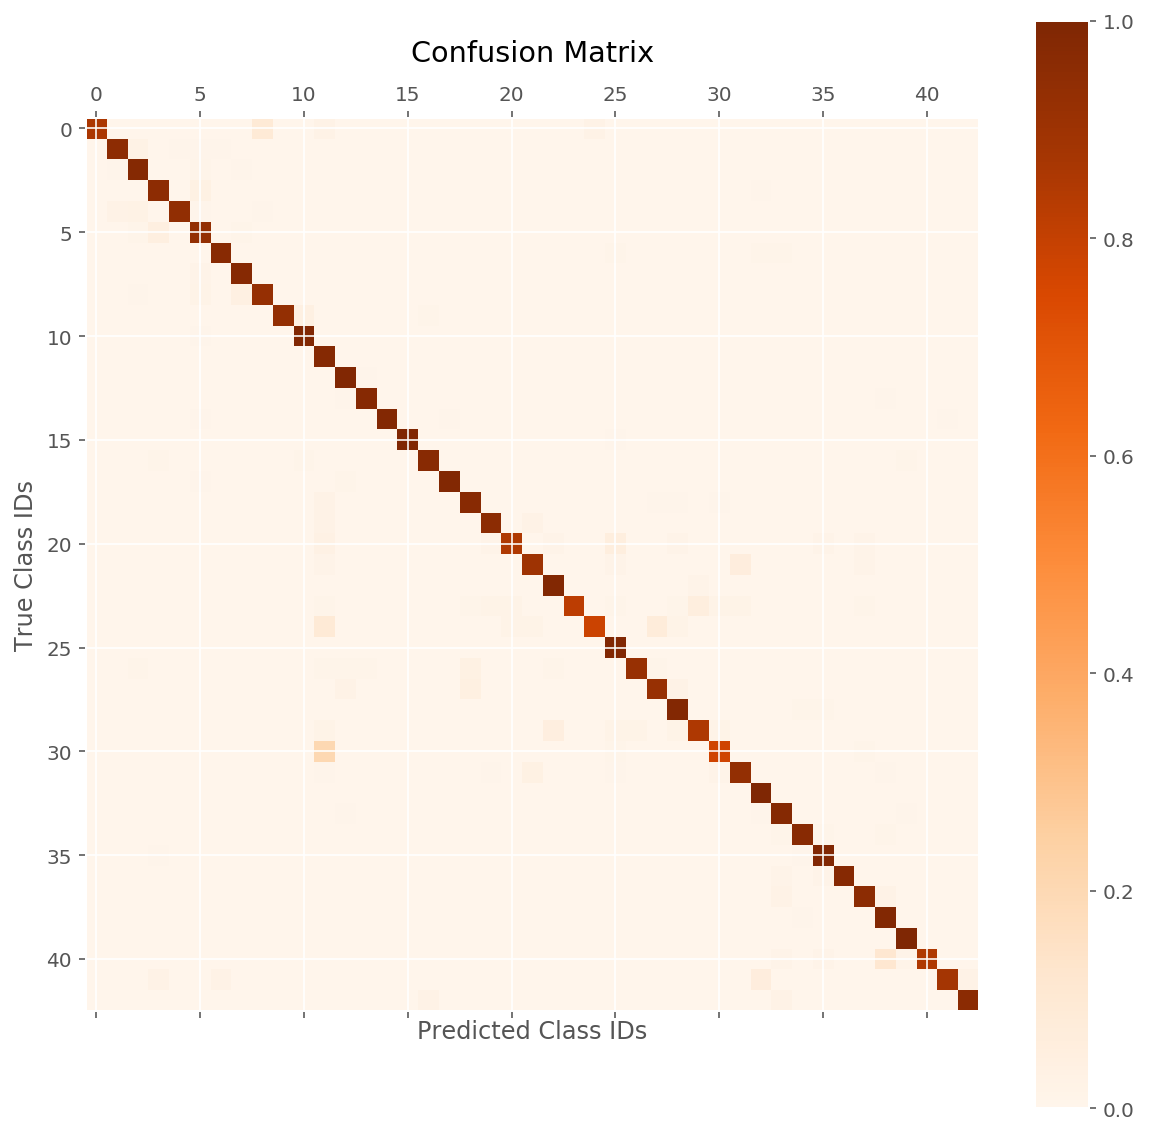

32 End of all speed and passing limits                100.00%  191
39 Keep left                                          100.00%  239
15 No vehicles                                         99.22%  501
35 Ahead only                                          99.18%  955
12 Priority road                                       99.07% 1672
10 No passing for vehicles over 3.5 metric tons        99.02% 1600
25 Road work                                           99.02% 1194
22 Bumpy road                                          98.75%  310
17 No entry                                            98.67%  884
38 Keep right                                          98.58% 1648
28 Children crossing                                   98.18%  430
14 Stop                                                98.11%  621
33 Turn right ahead                                    97.87%  548
 2 Speed limit (50km/h)                                97.82% 1791
11 Right-of-way at the next intersection               97.77% 

In [60]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20_lr-0.5e-3.ckpt') # load our best pipeline so far  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

I'm not sure if the worse performance is due to the smaller number of training images for that class or not.  There are some class that has many training images but still not performing well, too.

## Network 3 with Balanced Class Distribution of Training Data

Will it help to have a balanced class distribution of training data?

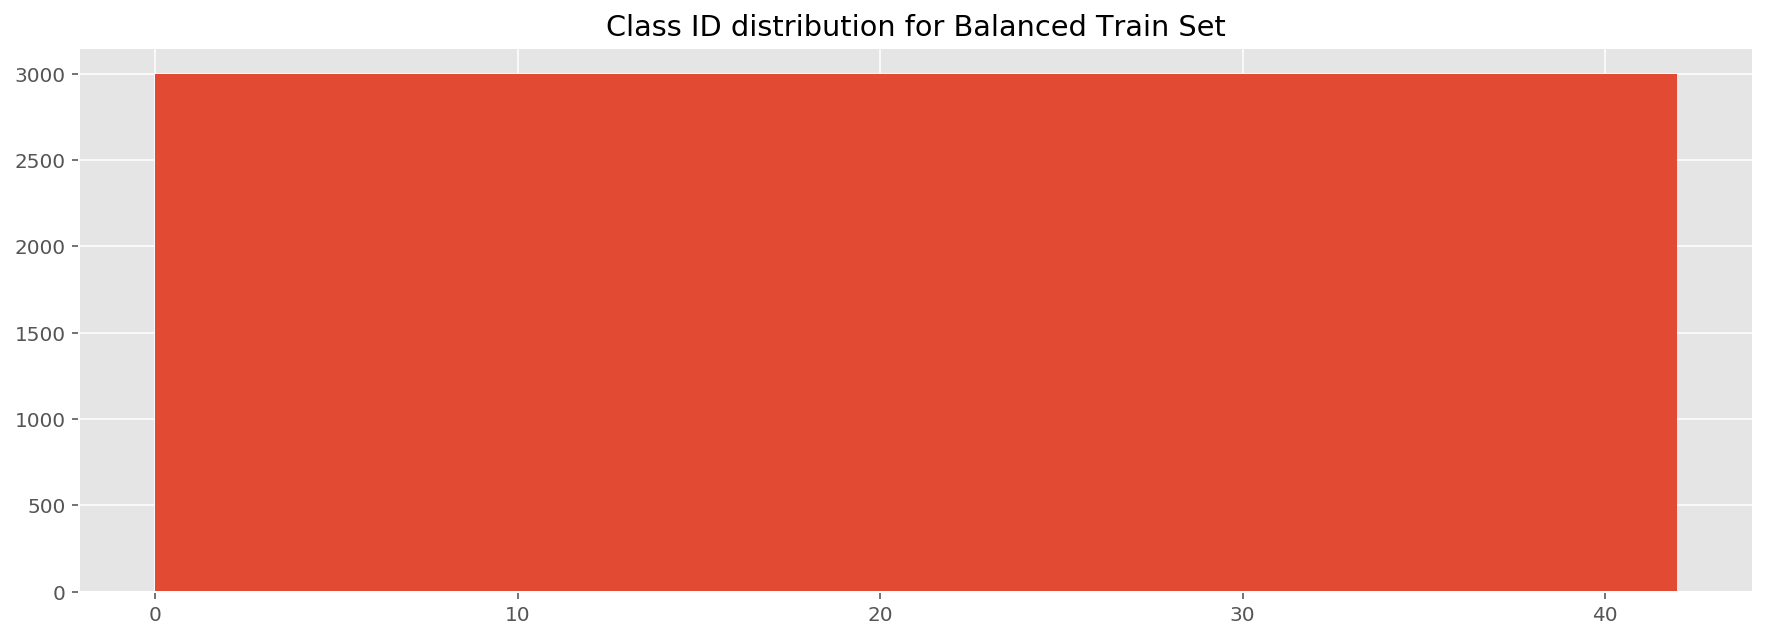

In [61]:
def balance_distribution(X, y, size):
    X_balanced = []
    y_balanced = []
    for c in range(N_CLASSES):
        data = X[y==c]
        indices = np.random.choice(sum(y==c), size)
        X_balanced.extend(X[y==c][indices])
        y_balanced.extend(y[y==c][indices])
    return np.array(X_balanced), np.array(y_balanced)

X_balanced, y_balanced = balance_distribution(X_train, y_train, 3000)

show_class_distribution(y_balanced, 'Balanced Train Set')

Let's try the balanced data set with our best pipeline (Network 3 with learning rate = 0.5e-3)

In [62]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3))
    train_evaluate(pipeline, epochs=20, train=(X_balanced, y_balanced)) # <== using the balanced train set

Epoch:   0 Train Score: 0.417 Evaluation Score: 0.390
Epoch:   1 Train Score: 0.623 Evaluation Score: 0.602
Epoch:   2 Train Score: 0.736 Evaluation Score: 0.692
Epoch:   3 Train Score: 0.786 Evaluation Score: 0.748
Epoch:   4 Train Score: 0.846 Evaluation Score: 0.808
Epoch:   5 Train Score: 0.876 Evaluation Score: 0.853
Epoch:   6 Train Score: 0.896 Evaluation Score: 0.869
Epoch:   7 Train Score: 0.909 Evaluation Score: 0.878
Epoch:   8 Train Score: 0.917 Evaluation Score: 0.894
Epoch:   9 Train Score: 0.933 Evaluation Score: 0.908
Epoch:  10 Train Score: 0.939 Evaluation Score: 0.917
Epoch:  11 Train Score: 0.932 Evaluation Score: 0.908
Epoch:  12 Train Score: 0.942 Evaluation Score: 0.914
Epoch:  13 Train Score: 0.952 Evaluation Score: 0.931
Epoch:  14 Train Score: 0.954 Evaluation Score: 0.936
Epoch:  15 Train Score: 0.960 Evaluation Score: 0.945
Epoch:  16 Train Score: 0.953 Evaluation Score: 0.934
Epoch:  17 Train Score: 0.966 Evaluation Score: 0.955
Epoch:  18 Train Score: 0.96

The validation accuracy is much worse than before.  This is likely because the distribution is different, indicating the network is learning the distribution which is different from the validation set.  Assuming the test set has the same kind of validation (we should not check the test set at this stage), using the balance set may not be a good idea.

Instead, we should do more epochs so that minor classes are more visible to the network.

## Network 3 with even more epochs

Let's just try with much more epochs.

In [63]:
def show_learning_curve(learning_curve):
    epochs, train, valid = learning_curve
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train, label='train')
    plt.plot(epochs, valid, label='validation')
    plt.title('Learning Curve')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(loc='center right')

In [64]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=100)
    
show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.454 Evaluation Score: 0.453
Epoch:   1 Train Score: 0.651 Evaluation Score: 0.656
Epoch:   2 Train Score: 0.756 Evaluation Score: 0.752
Epoch:   3 Train Score: 0.810 Evaluation Score: 0.809
Epoch:   4 Train Score: 0.860 Evaluation Score: 0.851
Epoch:   5 Train Score: 0.874 Evaluation Score: 0.873
Epoch:   6 Train Score: 0.890 Evaluation Score: 0.886
Epoch:   7 Train Score: 0.904 Evaluation Score: 0.899
Epoch:   8 Train Score: 0.922 Evaluation Score: 0.921
Epoch:   9 Train Score: 0.923 Evaluation Score: 0.921
Epoch:  10 Train Score: 0.935 Evaluation Score: 0.932
Epoch:  11 Train Score: 0.929 Evaluation Score: 0.927
Epoch:  12 Train Score: 0.946 Evaluation Score: 0.940
Epoch:  13 Train Score: 0.950 Evaluation Score: 0.946
Epoch:  14 Train Score: 0.955 Evaluation Score: 0.948
Epoch:  15 Train Score: 0.950 Evaluation Score: 0.947
Epoch:  16 Train Score: 0.948 Evaluation Score: 0.946
Epoch:  17 Train Score: 0.958 Evaluation Score: 0.954
Epoch:  18 Train Score: 0.95

It performs much better now but the last several epochs are not really helping for the network to learn.  I should try smaller learning rate to see how it goes.

## Network 3 with even lower learning rate (and more epochs)

Epoch:   0 Train Score: 0.173 Evaluation Score: 0.169
Epoch:   1 Train Score: 0.293 Evaluation Score: 0.292
Epoch:   2 Train Score: 0.400 Evaluation Score: 0.402
Epoch:   3 Train Score: 0.464 Evaluation Score: 0.458
Epoch:   4 Train Score: 0.533 Evaluation Score: 0.525
Epoch:   5 Train Score: 0.573 Evaluation Score: 0.569
Epoch:   6 Train Score: 0.623 Evaluation Score: 0.622
Epoch:   7 Train Score: 0.654 Evaluation Score: 0.654
Epoch:   8 Train Score: 0.699 Evaluation Score: 0.694
Epoch:   9 Train Score: 0.717 Evaluation Score: 0.705
Epoch:  10 Train Score: 0.736 Evaluation Score: 0.738
Epoch:  11 Train Score: 0.759 Evaluation Score: 0.752
Epoch:  12 Train Score: 0.766 Evaluation Score: 0.755
Epoch:  13 Train Score: 0.789 Evaluation Score: 0.785
Epoch:  14 Train Score: 0.799 Evaluation Score: 0.793
Epoch:  15 Train Score: 0.818 Evaluation Score: 0.813
Epoch:  16 Train Score: 0.826 Evaluation Score: 0.822
Epoch:  17 Train Score: 0.834 Evaluation Score: 0.829
Epoch:  18 Train Score: 0.84

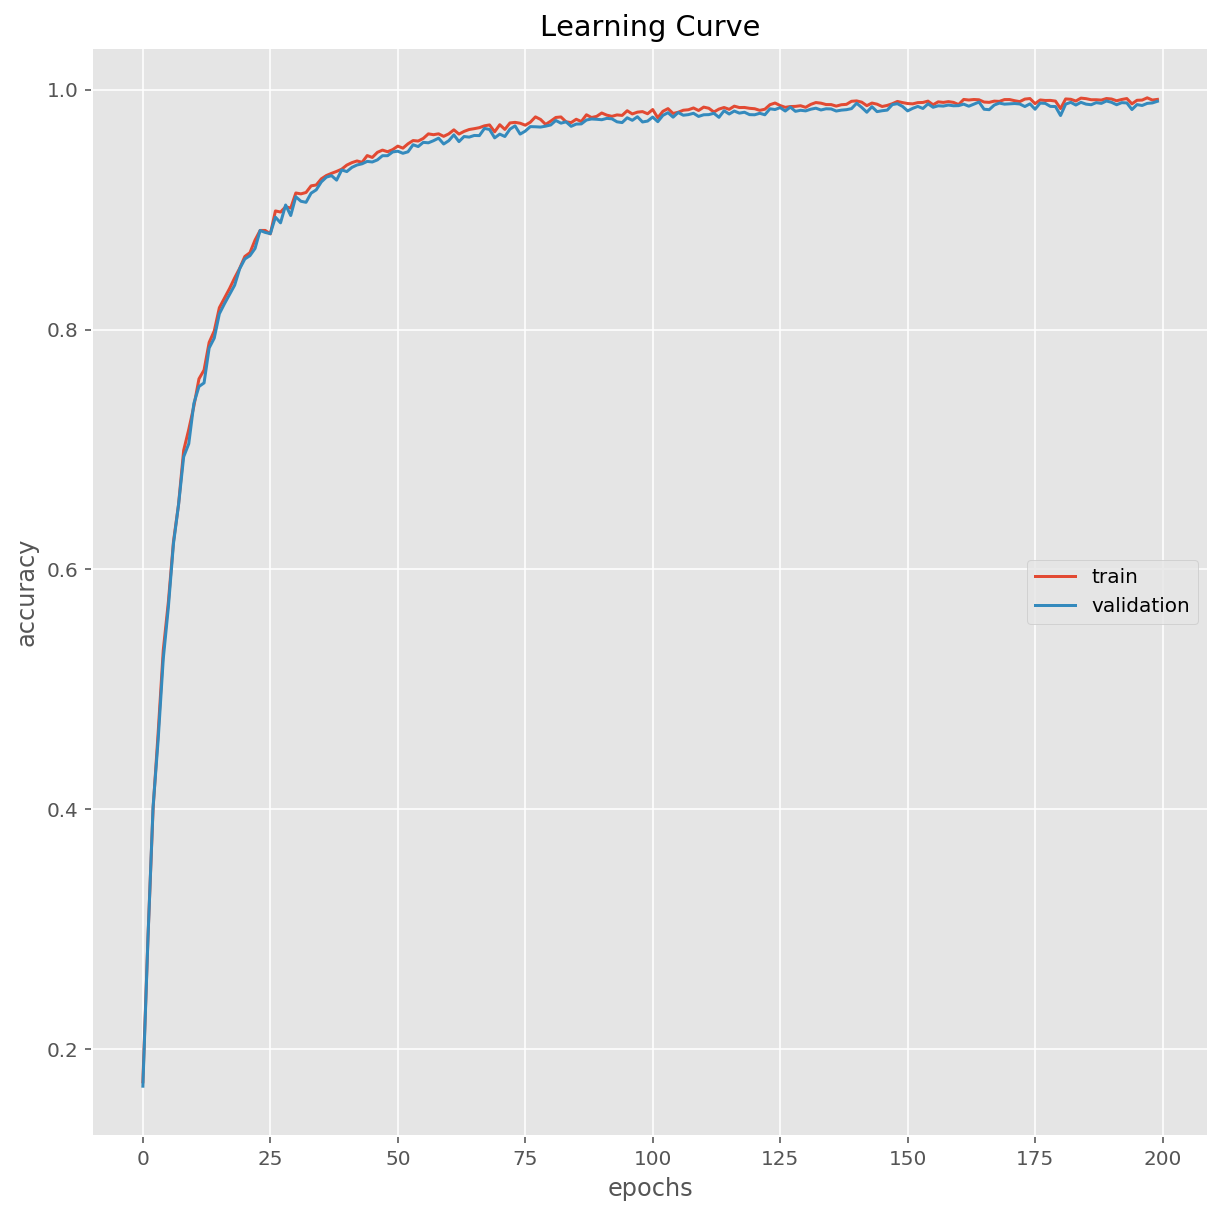

In [65]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-4))
    learning_curve = train_evaluate(pipeline, epochs=500)
    session.save('checkpoint/network3_epochs-500_lr-1.0e-4.ckpt')    
    
show_learning_curve(learning_curve)

This learning rate was probably too low?

The network is not improving in the last several epochs regardless of the learning rate.

How can we make the network more robust?  How about a dropout?

In [66]:
def make_network10(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .dropout(keep_prob=0.5)
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=500)
    session.save('checkpoint/network10.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.478 Evaluation Score: 0.481
Epoch:   1 Train Score: 0.650 Evaluation Score: 0.651
Epoch:   2 Train Score: 0.755 Evaluation Score: 0.745
Epoch:   3 Train Score: 0.816 Evaluation Score: 0.813
Epoch:   4 Train Score: 0.848 Evaluation Score: 0.852
Epoch:   5 Train Score: 0.885 Evaluation Score: 0.884
Epoch:   6 Train Score: 0.897 Evaluation Score: 0.889
Epoch:   7 Train Score: 0.918 Evaluation Score: 0.912
Epoch:   8 Train Score: 0.932 Evaluation Score: 0.925
Epoch:   9 Train Score: 0.932 Evaluation Score: 0.934
Epoch:  10 Train Score: 0.932 Evaluation Score: 0.930
Epoch:  11 Train Score: 0.947 Evaluation Score: 0.944
Epoch:  12 Train Score: 0.938 Evaluation Score: 0.940
Epoch:  13 Train Score: 0.950 Evaluation Score: 0.950
Epoch:  14 Train Score: 0.954 Evaluation Score: 0.955
Epoch:  15 Train Score: 0.950 Evaluation Score: 0.948
Epoch:  16 Train Score: 0.962 Evaluation Score: 0.961
Epoch:  17 Train Score: 0.964 Evaluation Score: 0.961
Epoch:  18 Train Score: 0.95

## Test Dataset

Test images are in one folder.  So, we can simply load them as follows:

Test images do not have category folders but all are kept in one place with one label file.

```
data
 + Final_Test
    + Images
        + 00000.ppm
        + 00001.ppm
        + ...
        + GT-final_test.csv      # Extended annotations including class ids
        + GT-final_test.test.csv
```

I also downloaded GT-final_test.csv which contains extended annotations including class ids for test images.

In [67]:
TEST_IMAGE_DIR = 'data/Final_Test/Images'

# Note: GT-final_test.csv comes with class IDs (GT-final_test.test.csv does not)
test_df = pd.read_csv(os.path.join(TEST_IMAGE_DIR, 'GT-final_test.csv'), sep=';')
test_df['Filename'] = test_df['Filename'].apply(lambda x: os.path.join(TEST_IMAGE_DIR, x))
test_df.head()

Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  \
0  data/Final_Test/Images/00000.ppm     53      54       6       5      48   
1  data/Final_Test/Images/00001.ppm     42      45       5       5      36   
2  data/Final_Test/Images/00002.ppm     48      52       6       6      43   
3  data/Final_Test/Images/00003.ppm     27      29       5       5      22   
4  data/Final_Test/Images/00004.ppm     60      57       5       5      55   

   Roi.Y2  ClassId  
0      49       16  
1      40        1  
2      47       38  
3      24       33  
4      52       11

In [68]:
print("Number of test images: {:>5}".format(test_df.shape[0]))

Number of test images: 12630


In [69]:
X_test = test_df['Filename'].values
y_test = test_df['ClassId'].values

In [70]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_test, y_test)
    print('Test Score: {:.3f}'.format(score))

Test Score: 0.952


# References:
    
- German Traffic Sign Benchmarks: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
- The PPM format (Portable Pixmap, P6): http://en.wikipedia.org/wiki/Netpbm_format
- LeNet Demo (Yann LeCun): http://yann.lecun.com/exdb/lenet/
- Gradient-Based Learning Applied to Document Recognition (Yann LeCun): http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
- Udacity: Self-Driving Car Engineer: Traffic Sign Classifier Project: https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project
